In [1]:
import datetime as dt
import gsw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PyCO2SYS as pyco2
import scipy.io as sio
import xarray as xr

### Initialize file

From Susans: like runoff, 2-dimensional as we assume wastewater goes in the bottom grid cell

In [12]:
# what coordinates are you using?
gridcoords = 'coordinates_seagrid_SalishSea201702.nc'
coords_file = '/home/sallen/MEOPAR/grid/'+gridcoords
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

In [13]:
#get dimensions for netcdf files
fB = xr.open_dataset(coords_file, decode_times=False)
lat = fB['nav_lat'][:]
lon = fB['nav_lon'][:]
e1t = fB['e1t'][0,:]
e2t = fB['e2t'][0,:]
horz_area = e1t*e2t
fB.close()

### Time (12 - monthly)

In [4]:
numtimes = 12

### Location

From /ocean/cstang/MOAD/analysis-camryn/OAE/Ariane/FindOutfallPoints.ipynb, gridpoints for Nanaimo WWTP is:

x: 215
y: 498

In [5]:
mbathy = mesh.mbathy[0]
mbathy[498,215].values
mesh.gdept_1d[0,25].values

array(76.58558445)

In [6]:
location = np.array([26,498,215])

## So Nanaimo going in at 98m???? Check this -> Should be 66 m

### Input Data

In [14]:
flux_m3d = np.array([48960,38196,38693,31203,29092,28800,27926,27800,28057,30724,45818,47561])
temp = np.array([13.9,13.8,13.9,15.4,17.3,18.9,21.1,21.3,20.2,17.7,15.4,14.4])
ammonia = 1457
nitrate = 322
PorgN = 66.7
DorgN = 102
oxygen = 184
alkalinity = 2118
DinorgC = 2475

#### Convert flux to kgm2/d

In [15]:
flux_kgs = flux_m3d*1025/24/60/60
flux_kgm2s = flux_kgs/500/440

In [18]:
flux_kgm2s

array([0.00264015, 0.00205971, 0.00208651, 0.00168261, 0.00156878,
       0.00155303, 0.0015059 , 0.00149911, 0.00151296, 0.00165678,
       0.00247072, 0.00256471])

In [9]:
flux = np.zeros((numtimes, horz_area.shape[0], horz_area.shape[1]))
flux[:, location[1], location[2]] = flux_kgm2s

#### Convert to conservative temperature

In [10]:
temperature = gsw.CT_from_pt(0, temp)

temp_cons = np.zeros_like(flux)
temp_cons[:, location[1], location[2]]  = temperature

In [11]:
temp_cons[:,498,215]

array([14.64697999, 14.54202257, 14.64697999, 16.22099806, 18.21391577,
       19.89153253, 22.19746224, 22.40705203, 21.25422873, 18.63337035,
       16.22099806, 15.171723  ])

### NH3

In [22]:
nh3 = np.zeros_like(flux)
nh3[:, location[1], location[2]]  = ammonia

In [23]:
nh3.shape

(12, 898, 398)

### NO3

In [24]:
no3 = np.zeros_like(flux)
no3[:, location[1], location[2]]  = nitrate

### PON

In [25]:
pon = np.zeros_like(flux)
pon[:, location[1], location[2]]  = PorgN

### DON

In [26]:
don = np.zeros_like(flux)
don[:, location[1], location[2]]  = DorgN

### Oxygen

In [27]:
do = np.zeros_like(flux)
do[:, location[1], location[2]]  = oxygen

### Alkalinity

In [28]:
ta = np.zeros_like(flux)
ta[:, location[1], location[2]]  = alkalinity

### DIC

In [29]:
dic = np.zeros_like(flux)
dic[:, location[1], location[2]]  = DinorgC

### Turbidity

In [30]:
turb = np.zeros_like(flux)

### Biota (zeros)

In [13]:
zeros = np.zeros_like(flux)

## Create File

In [32]:
# set up titles
netcdf_title = 'wastewaterNanaimo_20240601_wNutrients_Adjusted'
netcdf_comment = netcdf_title+' on '+ gridcoords
notebook = 'Wastewater_CreateInputFiles.ipynb'

ds_attrs = {
    'acknowledgements':
            'Based on Nanaimo WWTP and climatology',
        'creator_email':
            'cstang@eoas.ubc.ca',
        'institution':
            'UBC EOAS',
        'institution_fullname': (
            'Earth, Ocean & Atmospheric Sciences,'
            ' University of British Columbia'
        ),
    'title': netcdf_title,
    'comment': netcdf_comment,
    'notebook': notebook,
    'history': (
            '[{}] File creation.'
            .format(dt.datetime.today().strftime('%Y-%m-%d'))
        )
}

coords_c = {
    'x' : np.arange(horz_area.shape[1]),
    'y' : np.arange(horz_area.shape[0]),
}

coords = {
    'x' : np.arange(horz_area.shape[1]),
    'y' : np.arange(horz_area.shape[0]),
     'time_counter' : np.arange(numtimes)
}

data_c = {}
var_attrs_c = {} 
data_c['nav_lat'] = lat
var_attrs_c['nav_lat'] = {'units': 'degrees_north',
                       'long_name': 'latitude'}
data_c['nav_lon'] = lon
var_attrs_c['nav_lon'] = {'units': 'degrees_east',
                       'long_name': 'latitude'}
data_c['area'] = horz_area
var_attrs_c['area'] = {'units': 'm2',
                     'long_name': 'horizontal_grid_cell_area'}

da = {}
for var in data_c:
    da[var] = xr.DataArray(
        data = data_c[var],
        name=var,
        dims=('y', 'x'),
        coords = coords_c,
        attrs = var_attrs_c[var])

data = {}
var_attrs = {}

var_attrs['flux'] = {'units': 'kg m-2 s-1',
                      'long_name': 'wastewater_flux'}
data['flux'] = flux

var_attrs['temperature'] = {'units': 'oC',
                      'long_name': 'wastewater conservative temperature'}
data['temperature'] = temp_cons

var_attrs['NO3'] = {'units': 'umol/L',
                    'long_name' : 'wastewater Nitrate + Nitrite'}
data['NO3'] = no3

var_attrs['NH3'] = {'units': 'umol/L',
                    'long_name' : 'wastewater ammonium'}
data['NH3'] = nh3

var_attrs['dSi'] = {'units': 'umol/L',
                    'long_name' : 'wastewater dissolved silion'}
data['dSi'] = zeros

var_attrs['diatoms'] = {'units': 'umol/L',
                    'long_name' : 'wastewater diatoms'}
data['diatoms'] = zeros

var_attrs['nanoflagellates'] = {'units': 'umol/L',
                    'long_name' : 'wastewater nanoflagellates'}
data['nanoflagellates'] = zeros

var_attrs['Z1'] = {'units': 'umol/L',
                    'long_name' : 'wastewater Z1 zooplankton'}
data['Z1'] = zeros

var_attrs['PON'] = {'units': 'umol/L',
                    'long_name' : 'wastewater labile particulate organic nitrogen'}
data['PON'] = pon

var_attrs['DON'] = {'units': 'umol/L',
                    'long_name' : 'wastewater labile dissolved organic nitrogen'}
data['DON'] = don

var_attrs['bSi'] = {'units': 'umol/L',
                    'long_name' : 'biogenic silicon'}
data['bSi'] = zeros

var_attrs['oxygen'] = {'units': 'umol/L',
                    'long_name' : 'dissolved oxygen'}
data['oxygen'] = do

var_attrs['alkalinity'] = {'units': 'umol/L',
                    'long_name' : 'carbonate alkalinity'}
data['alkalinity'] = ta

var_attrs['DIC'] = {'units': 'umol/L',
                    'long_name' : 'dissolved inorganic carbon'}
data['DIC'] = dic

var_attrs['DIC'] = {'units': 'umol/L',
                    'long_name' : 'dissolved inorganic carbon'}
data['DIC'] = dic

var_attrs['turb'] = {'units': 'NTU',
                    'long_name' : 'turbidity'}
data['turb'] = turb

for var in data:
    da[var] = xr.DataArray(
        data = data[var],
        name=var,
        dims=('time_counter', 'y', 'x'),
        coords = coords,
        attrs = var_attrs[var])
    

ds = xr.Dataset(
        data_vars={
            'nav_lat': da['nav_lat'],
            'nav_lon': da['nav_lon'],
            'area': da['area'],
            'flux': da['flux'],
            'temperature': da['temperature'],
            'NO3': da['NO3'],
            'NH3': da['NH3'],
            'dSi': da['dSi'],
            'diatoms': da['diatoms'],
            'nanoflagellates': da['nanoflagellates'],
            'Z1': da['Z1'],
            'PON': da['PON'],
            'DON': da['DON'],
            'bSi': da['bSi'],
            'oxygen': da['oxygen'],
            'alkalinity': da['alkalinity'],
            'DIC': da['DIC'],
            'turb': da['turb'],
            },
        coords = coords,
        attrs = ds_attrs
)

ds

<xarray.Dataset>
Dimensions:          (x: 398, y: 898, time_counter: 12)
Coordinates:
  * x                (x) int64 0 1 2 3 4 5 6 7 ... 391 392 393 394 395 396 397
  * y                (y) int64 0 1 2 3 4 5 6 7 ... 891 892 893 894 895 896 897
  * time_counter     (time_counter) int64 0 1 2 3 4 5 6 7 8 9 10 11
Data variables: (12/18)
    nav_lat          (y, x) float32 46.86 46.86 46.86 46.87 ... 51.1 51.1 51.1
    nav_lon          (y, x) float32 -123.4 -123.4 -123.4 ... -124.3 -124.3
    area             (y, x) float64 1.852e+05 1.908e+05 ... 1.764e+05 1.755e+05
    flux             (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    temperature      (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    NO3              (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...               ...
    DON              (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    bSi              (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    oxygen           (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    alkalinity       (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    DIC              (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    turb             (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    acknowledgements:      Based on Nanaimo WWTP and climatology
    creator_email:         cstang@eoas.ubc.ca
    institution:           UBC EOAS
    institution_fullname:  Earth, Ocean & Atmospheric Sciences, University of...
    title:                 wastewaterNanaimo_20240601_wNutrients_Adjusted
    comment:               wastewaterNanaimo_20240601_wNutrients_Adjusted on ...
    notebook:              Wastewater_CreateInputFiles.ipynb
    history:               [2025-10-29] File creation.

In [33]:
encoding = {var: {'zlib': True} for var in ds.data_vars}

In [34]:
ds.to_netcdf(f'Nanaimo/{netcdf_title}.nc', unlimited_dims=('time_counter'),
        encoding=encoding,)

In [35]:
xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/OAE/DyeTracing/Nanaimo/wastewaterNanaimo_20240601_wNutrients.nc')

<xarray.Dataset>
Dimensions:          (x: 398, y: 898, time_counter: 12)
Coordinates:
  * x                (x) int64 0 1 2 3 4 5 6 7 ... 391 392 393 394 395 396 397
  * y                (y) int64 0 1 2 3 4 5 6 7 ... 891 892 893 894 895 896 897
  * time_counter     (time_counter) int64 0 1 2 3 4 5 6 7 8 9 10 11
Data variables: (12/18)
    nav_lat          (y, x) float32 ...
    nav_lon          (y, x) float32 ...
    area             (y, x) float64 ...
    flux             (time_counter, y, x) float64 ...
    temperature      (time_counter, y, x) float64 ...
    NO3              (time_counter, y, x) float64 ...
    ...               ...
    DON              (time_counter, y, x) float64 ...
    bSi              (time_counter, y, x) float64 ...
    oxygen           (time_counter, y, x) float64 ...
    alkalinity       (time_counter, y, x) float64 ...
    DIC              (time_counter, y, x) float64 ...
    turb             (time_counter, y, x) float64 ...
Attributes:
    acknowledgements:      Based on Nanaimo WWTP and climatology
    creator_email:         cstang@eoas.ubc.ca
    institution:           UBC EOAS
    institution_fullname:  Earth, Ocean & Atmospheric Sciences, University of...
    title:                 wastewaterNanaimo_20240601_wNutrients
    comment:               wastewaterNanaimo_20240601_wNutrients on coordinat...
    notebook:              Wastewater_CreateInputFiles.ipynb
    history:               [2025-10-17] File creation.

### No Nutrients

In [14]:
# set up titles
netcdf_title = 'wastewaterNanaimo_20240601_noNutrients_Adjusted'
netcdf_comment = netcdf_title+' on '+ gridcoords
notebook = 'Wastewater_CreateInputFiles.ipynb'

ds_attrs = {
    'acknowledgements':
            'Based on Nanaimo WWTP and climatology',
        'creator_email':
            'cstang@eoas.ubc.ca',
        'institution':
            'UBC EOAS',
        'institution_fullname': (
            'Earth, Ocean & Atmospheric Sciences,'
            ' University of British Columbia'
        ),
    'title': netcdf_title,
    'comment': netcdf_comment,
    'notebook': notebook,
    'history': (
            '[{}] File creation.'
            .format(dt.datetime.today().strftime('%Y-%m-%d'))
        )
}

coords_c = {
    'x' : np.arange(horz_area.shape[1]),
    'y' : np.arange(horz_area.shape[0]),
}

coords = {
    'x' : np.arange(horz_area.shape[1]),
    'y' : np.arange(horz_area.shape[0]),
     'time_counter' : np.arange(numtimes)
}

data_c = {}
var_attrs_c = {} 
data_c['nav_lat'] = lat
var_attrs_c['nav_lat'] = {'units': 'degrees_north',
                       'long_name': 'latitude'}
data_c['nav_lon'] = lon
var_attrs_c['nav_lon'] = {'units': 'degrees_east',
                       'long_name': 'latitude'}
data_c['area'] = horz_area
var_attrs_c['area'] = {'units': 'm2',
                     'long_name': 'horizontal_grid_cell_area'}

da = {}
for var in data_c:
    da[var] = xr.DataArray(
        data = data_c[var],
        name=var,
        dims=('y', 'x'),
        coords = coords_c,
        attrs = var_attrs_c[var])

data = {}
var_attrs = {}

var_attrs['flux'] = {'units': 'kg m-2 s-1',
                      'long_name': 'wastewater_flux'}
data['flux'] = flux

var_attrs['temperature'] = {'units': 'oC',
                      'long_name': 'wastewater conservative temperature'}
data['temperature'] = temp_cons

var_attrs['NO3'] = {'units': 'umol/L',
                    'long_name' : 'wastewater Nitrate + Nitrite'}
data['NO3'] = zeros

var_attrs['NH3'] = {'units': 'umol/L',
                    'long_name' : 'wastewater ammonium'}
data['NH3'] = zeros

var_attrs['dSi'] = {'units': 'umol/L',
                    'long_name' : 'wastewater dissolved silion'}
data['dSi'] = zeros

var_attrs['diatoms'] = {'units': 'umol/L',
                    'long_name' : 'wastewater diatoms'}
data['diatoms'] = zeros

var_attrs['nanoflagellates'] = {'units': 'umol/L',
                    'long_name' : 'wastewater nanoflagellates'}
data['nanoflagellates'] = zeros

var_attrs['Z1'] = {'units': 'umol/L',
                    'long_name' : 'wastewater Z1 zooplankton'}
data['Z1'] = zeros

var_attrs['PON'] = {'units': 'umol/L',
                    'long_name' : 'wastewater labile particulate organic nitrogen'}
data['PON'] = zeros

var_attrs['DON'] = {'units': 'umol/L',
                    'long_name' : 'wastewater labile dissolved organic nitrogen'}
data['DON'] = zeros

var_attrs['bSi'] = {'units': 'umol/L',
                    'long_name' : 'biogenic silicon'}
data['bSi'] = zeros

var_attrs['oxygen'] = {'units': 'umol/L',
                    'long_name' : 'dissolved oxygen'}
data['oxygen'] = zeros

var_attrs['alkalinity'] = {'units': 'umol/L',
                    'long_name' : 'carbonate alkalinity'}
data['alkalinity'] = zeros

var_attrs['DIC'] = {'units': 'umol/L',
                    'long_name' : 'dissolved inorganic carbon'}
data['DIC'] = zeros

var_attrs['DIC'] = {'units': 'umol/L',
                    'long_name' : 'dissolved inorganic carbon'}
data['DIC'] = zeros

var_attrs['turb'] = {'units': 'NTU',
                    'long_name' : 'turbidity'}
data['turb'] = zeros

for var in data:
    da[var] = xr.DataArray(
        data = data[var],
        name=var,
        dims=('time_counter', 'y', 'x'),
        coords = coords,
        attrs = var_attrs[var])
    

ds = xr.Dataset(
        data_vars={
            'nav_lat': da['nav_lat'],
            'nav_lon': da['nav_lon'],
            'area': da['area'],
            'flux': da['flux'],
            'temperature': da['temperature'],
            'NO3': da['NO3'],
            'NH3': da['NH3'],
            'dSi': da['dSi'],
            'diatoms': da['diatoms'],
            'nanoflagellates': da['nanoflagellates'],
            'Z1': da['Z1'],
            'PON': da['PON'],
            'DON': da['DON'],
            'bSi': da['bSi'],
            'oxygen': da['oxygen'],
            'alkalinity': da['alkalinity'],
            'DIC': da['DIC'],
            'turb': da['turb'],
            },
        coords = coords,
        attrs = ds_attrs
)

ds

<xarray.Dataset>
Dimensions:          (x: 398, y: 898, time_counter: 12)
Coordinates:
  * x                (x) int64 0 1 2 3 4 5 6 7 ... 391 392 393 394 395 396 397
  * y                (y) int64 0 1 2 3 4 5 6 7 ... 891 892 893 894 895 896 897
  * time_counter     (time_counter) int64 0 1 2 3 4 5 6 7 8 9 10 11
Data variables: (12/18)
    nav_lat          (y, x) float32 46.86 46.86 46.86 46.87 ... 51.1 51.1 51.1
    nav_lon          (y, x) float32 -123.4 -123.4 -123.4 ... -124.3 -124.3
    area             (y, x) float64 1.852e+05 1.908e+05 ... 1.764e+05 1.755e+05
    flux             (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    temperature      (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    NO3              (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...               ...
    DON              (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    bSi              (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    oxygen           (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    alkalinity       (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    DIC              (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    turb             (time_counter, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    acknowledgements:      Based on Nanaimo WWTP and climatology
    creator_email:         cstang@eoas.ubc.ca
    institution:           UBC EOAS
    institution_fullname:  Earth, Ocean & Atmospheric Sciences, University of...
    title:                 wastewaterNanaimo_20240601_noNutrients_Adjusted
    comment:               wastewaterNanaimo_20240601_noNutrients_Adjusted on...
    notebook:              Wastewater_CreateInputFiles.ipynb
    history:               [2025-10-30] File creation.

In [16]:
encoding = {var: {'zlib': True} for var in ds.data_vars}

In [17]:
ds.to_netcdf(f'Nanaimo/{netcdf_title}.nc', unlimited_dims=('time_counter'),
        encoding=encoding,)

In [3]:
test1 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/OAE/DyeTracing/Nanaimo/wastewaterNanaimo_20240601_wNutrients_Adjusted.nc')

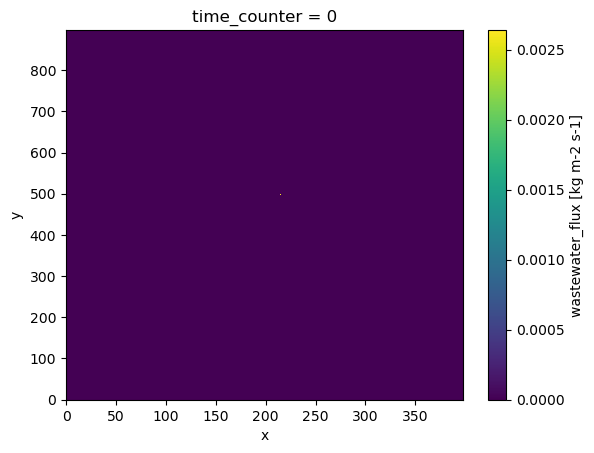

In [10]:
test1.flux[0].plot()